In [1]:
from typing import Callable, Tuple

import numpy as np
import pandas as pd
from numba import prange, njit, typed, types
from tqdm.notebook import trange
from numpy.typing import NDArray
from numba import njit, prange
import matplotlib.pyplot as plt
from scipy import stats

from util import normalize_values, ideal_point_method, linear_convolution, little_law

In [2]:
def get_service_times() -> NDArray['float']:
    df = pd.read_csv('../data/service_times.csv')
    df.rename(columns={'TTI 0.95': 'service_time' }, inplace=True)
    df['service_time'] = df['service_time'].map(lambda time: float(time.replace('ms', '')))

    return np.array(df['service_time'])

In [3]:
service_times = get_service_times()

In [4]:
@njit
def arrive_cdf() -> float:
    return np.random.exponential(0.299)
    
@njit
def leave_cdf() -> float:
    return np.random.exponential(510)

@njit
def departure_cdf() -> float:
    return np.random.choice(service_times) / 4

In [5]:
@njit
def get_next_event(
    arrival_time: float,
    request_times_queue: list,
    departure_times: list,
) -> (float, str, int):
    event_type = 'ARRIVAL'
    min_index = -1
    min_time = arrival_time

    min_departure_time_index = -1
    min_departure_time = np.inf
    for i in range(len(departure_times)):
        if departure_times[i] != -1 and departure_times[i] < min_departure_time:
            min_departure_time_index = i
            min_departure_time = departure_times[i]

    min_leave_time_index = -1
    min_leave_time = np.inf
    if len(request_times_queue) != 0:
        min_leave_time_index = np.argmin(request_times_queue)
    if min_leave_time_index != -1:
        min_leave_time = request_times_queue[min_leave_time_index]

    if min_departure_time < min_time:
        min_index = min_departure_time_index
        min_time = min_departure_time
        event_type = 'DEPARTURE'
    if min_leave_time < min_time:
        min_index = min_leave_time_index
        min_time = min_leave_time
        event_type = 'LEAVE'

    return min_time, event_type, min_index

In [6]:
@njit
def arrival(
    time: float,
    num_in_system: int,
    num_total_requests: int,
    leave_indicator: int,
    request_times_queue: list,
    departure_times: list,
    N: int
) -> (float, int, int, int, list, list):
    all_servers_busy = True

    num_in_system += 1 # увеличиваем число запросов в системе
    num_total_requests += 1
    
    for i in range (len(departure_times)):
        if departure_times[i] == -1: # если сервер свободен
            all_servers_busy = False

            mu = departure_cdf()
            departure_times[i] = time
            departure_times[i] = time + mu # планируем обработку запроса
            break

    if all_servers_busy:
        gamma = leave_cdf()
        if len(request_times_queue) == N:
            num_in_system -= 1 # считаем, что заявка покинула систему
            leave_indicator += 1 # увеличиваем индикатор выхода из системы
        else:
            request_times_queue = np.append(request_times_queue, time + gamma)
    
    alpha = arrive_cdf()
    time += alpha
    return time, num_in_system, num_total_requests, leave_indicator, request_times_queue, departure_times

@njit
def departure(
    time: float,
    time_index: float,
    num_in_system: int,
    request_times_queue: list,
    departure_times: list,
) -> (int, list, list):
    num_in_system -= 1 # запрос обработан - уменьшаем число запросов в системе
    
    if (len(request_times_queue) == 0): # если очередь пуста
        departure_times[time_index] = -1
    else:        
        gamma = departure_cdf()
        departure_times[time_index] = time + gamma # планируем обработку запроса
        request_times_queue = np.delete(request_times_queue, 0)
    return num_in_system, request_times_queue, departure_times

@njit
def on_leave(
    time_index: float,
    num_in_system: int,
    leave_indicator: int,
    request_times_queue: list
) -> (int, int, list):
    num_in_system -= 1 # запрос ушёл - уменьшаем число запросов в системе
    leave_indicator += 1 # увеличиваем индикатор выхода из системы
    
    request_times_queue = np.delete(request_times_queue, time_index)

    return num_in_system, leave_indicator, request_times_queue

In [7]:
@njit
def update_area_num_in_system_stat(
    time: float,
    past_event_time: float,
    num_in_system: int,
    area_num_in_system: float
) -> (float, float):
    time_since_past_event = time - past_event_time
    past_event_time = time

    area_num_in_system += (num_in_system * time_since_past_event)
    return past_event_time, area_num_in_system

In [8]:
@njit
def num_in_system_iteration(
    T: float,
    n: int,
    N: int,
    return_value: str = 'average_requests_in_system'
) -> float:
    time = 0.0
    past_event_time = 0.0

    num_in_system = 0
    area_num_in_system: float = 0.0

    num_total_requests = 0
    leave_indicator = 0
    
    arrival_time = arrive_cdf()
    leave = leave_cdf()

    departure_times = np.full(n, -1, dtype=np.float64)
    request_times_queue = np.empty(0, dtype=np.float64)
    
    while time < T:
        time, event_type, time_index = get_next_event(arrival_time, request_times_queue, departure_times)
        past_event_time, area_num_in_system = update_area_num_in_system_stat(
            time,
            past_event_time,
            num_in_system,
            area_num_in_system
        )
        
        if event_type == 'ARRIVAL':
            arrival_time, num_in_system, num_total_requests, leave_indicator, request_times_queue, departure_times = arrival(
                time,
                num_in_system,
                num_total_requests,
                leave_indicator,
                request_times_queue,
                departure_times,
                N
            )
        elif event_type == 'DEPARTURE':
            num_in_system, request_times_queue, departure_times = departure(
                time,
                time_index,
                num_in_system,
                request_times_queue,
                departure_times
            )
        else:
            num_in_system, leave_indicator, request_times_queue = on_leave(
                time_index,
                num_in_system,
                leave_indicator,
                request_times_queue
            )

    average_requests_in_system = area_num_in_system / time
    loss_probability = leave_indicator / num_total_requests

    if return_value == 'average_requests_in_system':
        return average_requests_in_system
    if return_value == 'loss_probability':
        return loss_probability

In [9]:
@njit(parallel=True)
def num_in_system_iteration_resolver(
    T: float,
    N: int,
    n: int,
    max_queue_size: int,
    x_betta: float,
    eps: float = 1e-3,
    return_value: str = 'average_requests_in_system'
) -> float:
    N_new = N
    N_old = 0

    sum_data = 0
    sum_data_sq = 0
    while True: 
        for i in prange(N - N_old):
            value = num_in_system_iteration(T, n, max_queue_size, return_value)
            sum_data += value
            sum_data_sq += value ** 2
        E = sum_data / N
        D = (sum_data_sq / N) - (E ** 2)
        N_new = int(((x_betta ** 2) * D) / (eps ** 2))

        if N_new <= N:
            return E
        N_old = N
        N = N_new
        
        print(f'New N: {N}, old N: {N_old}')

In [10]:
MAX_SERVERS = 200
MIN_SERVERS = 1

servers_num = np.arange(MIN_SERVERS, MAX_SERVERS + 1)

In [11]:
loss_probabilities = np.empty(0)

T = 10000
iterations = 1000
max_queue_size = 10_000
eps = 1e-3
betta = 0.95
x_betta = stats.norm.ppf(betta)

for i in trange(MIN_SERVERS, MAX_SERVERS + 1):    
    loss_probability = num_in_system_iteration_resolver(
        T,
        iterations,
        i,
        max_queue_size,
        x_betta=x_betta,
        eps=eps,
        return_value = 'loss_probability'
    )
    print(f'Probability of loss: {loss_probability} for servers number: {i}')
    loss_probabilities = np.append(loss_probabilities, loss_probability)

with open('./multichannel/loss_probabilities.npy', 'wb') as f:
    np.save(f, loss_probabilities)

  0%|          | 0/200 [00:00<?, ?it/s]

Probability of loss: 0.9414058612257921 for servers number: 1
Probability of loss: 0.9339193641256982 for servers number: 2
Probability of loss: 0.926319877931194 for servers number: 3
Probability of loss: 0.9188040278223424 for servers number: 4
Probability of loss: 0.911290816991962 for servers number: 5
Probability of loss: 0.9037733661165904 for servers number: 6
Probability of loss: 0.8962322542433763 for servers number: 7
Probability of loss: 0.8886786407908056 for servers number: 8
Probability of loss: 0.881177320926422 for servers number: 9
Probability of loss: 0.8736294880456982 for servers number: 10
Probability of loss: 0.866003024951955 for servers number: 11
Probability of loss: 0.8585764176147442 for servers number: 12
Probability of loss: 0.8509355355764746 for servers number: 13
Probability of loss: 0.8433662424470748 for servers number: 14
Probability of loss: 0.8358680981935047 for servers number: 15
Probability of loss: 0.8282637112918416 for servers number: 16
Proba

In [12]:
requests_in_system_list = np.empty(0)

T = 10000
iterations = 1000
max_queue_size = 10_000
eps = 1e-0
betta = 0.95
x_betta = stats.norm.ppf(betta)

for i in trange(MIN_SERVERS, MAX_SERVERS + 1):    
    avarege_requests_in_system = num_in_system_iteration_resolver(
        T,
        iterations,
        i,
        max_queue_size,
        x_betta=x_betta,
        eps=eps,
        return_value = 'average_requests_in_system'
    )
    print(f'Avarege requests in system: {avarege_requests_in_system} for servers number: {i}')
    requests_in_system_list = np.append(requests_in_system_list, avarege_requests_in_system)

with open('./multichannel/requests_in_system_list.npy', 'wb') as f:
    np.save(f, requests_in_system_list)

  0%|          | 0/200 [00:00<?, ?it/s]

Avarege requests in system: 1607.0945302270372 for servers number: 1
Avarege requests in system: 1594.5476025583512 for servers number: 2
Avarege requests in system: 1582.4006500179823 for servers number: 3
Avarege requests in system: 1571.0386145662142 for servers number: 4
Avarege requests in system: 1558.3940442113449 for servers number: 5
Avarege requests in system: 1547.8521051587597 for servers number: 6
Avarege requests in system: 1534.8817332871265 for servers number: 7
Avarege requests in system: 1522.9077435399868 for servers number: 8
Avarege requests in system: 1512.3239337379257 for servers number: 9
Avarege requests in system: 1499.7339219161827 for servers number: 10
Avarege requests in system: 1488.440107890049 for servers number: 11
Avarege requests in system: 1476.593101035621 for servers number: 12
Avarege requests in system: 1464.610684111079 for servers number: 13
Avarege requests in system: 1452.6016840065863 for servers number: 14
Avarege requests in system: 1440

In [13]:
def little_law(lambda_val: float, requests_in_system, loss_probability: float):
    return requests_in_system / (lambda_val * (1 - loss_probability))

In [14]:
def normalize_values(data: NDArray[float]) -> NDArray[float]:
    min = np.min(data)
    max = np.max(data)

    return (data - min) / (max - min)

In [15]:
lambda_val = 1 / 0.299
requests_in_system_list = np.load('./multichannel/requests_in_system_list.npy')
loss_probabilities = np.load('./multichannel/loss_probabilities.npy')

response_times = np.empty(len(requests_in_system_list))
for i in range(len(response_times)):
    response_times[i] = little_law(lambda_val, requests_in_system_list[i], loss_probabilities[i])

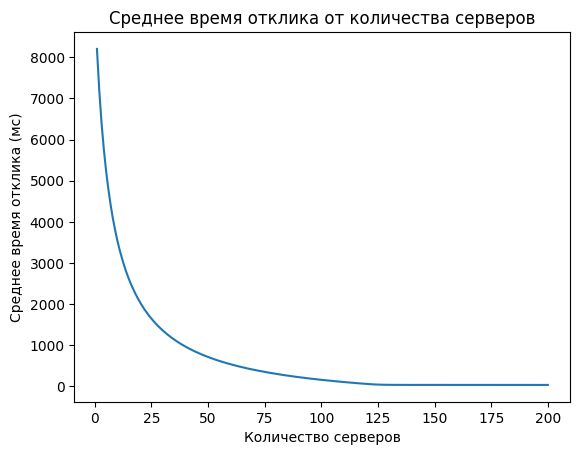

In [16]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Среднее время отклика (мс)')
plt.xlabel('Количество серверов')
plt.title(title)

plt.plot(servers_num, response_times)

plt.show()

In [17]:
normalized_response_times = normalize_values(response_times)
normalized_servers_num = normalize_values(servers_num)

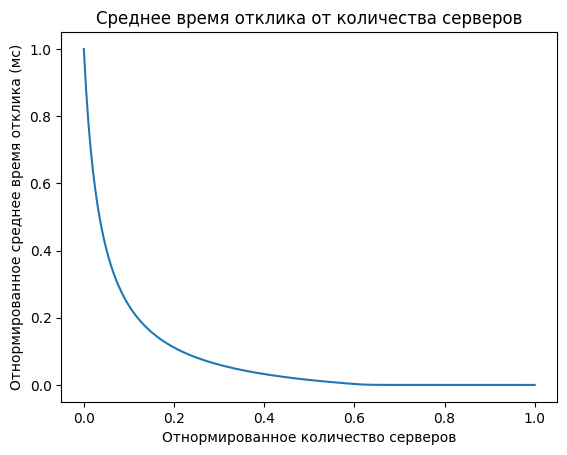

In [18]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Отнормированное среднее время отклика (мс)')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, normalized_response_times)

plt.show()

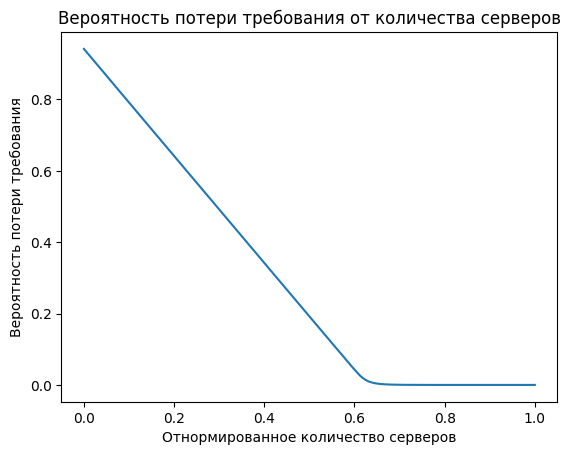

In [19]:
title = 'Вероятность потери требования от количества серверов'
        
plt.ylabel('Вероятность потери требования')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, loss_probabilities)

plt.show()

In [20]:
def ideal_point_method(
    X: NDArray[float],
    Y: NDArray[float],
    Z: NDArray[float],
    ideal_point: (float, float, float)
) -> NDArray[float]:
    points_num = len(X)
    distances = np.empty(points_num, dtype=float)

    for i in range(points_num):
        distances[i] = np.sqrt((X[i] - ideal_point[0]) ** 2 + (Y[i] - ideal_point[1]) ** 2 + (Z[i] - ideal_point[2]) ** 2)

    return distances

def linear_convolution(
    X: NDArray[float],
    Y: NDArray[float],
    Z: NDArray[float],
    weights: (float, float, float)
) -> NDArray[float]:
    return weights[0] * X + weights[1] * Y + weights[2] * Z

In [21]:
ideal_point = (0, 0, 0)
ideal_point_method_result = ideal_point_method(normalized_servers_num, normalized_response_times, loss_probabilities, (0, 0, 0))

optimal_index = np.argmin(ideal_point_method_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

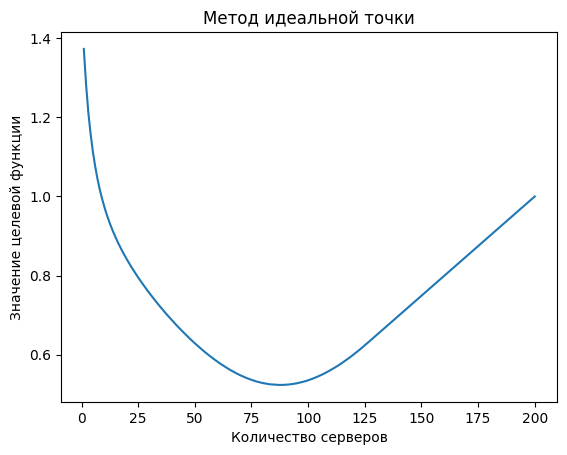

In [22]:
plt.title('Метод идеальной точки')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, ideal_point_method_result)

plt.show()

In [23]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 88
Время отклика: 241.3340458840651
Вероятность потери заявки: 0.28613571913960495


In [30]:
weights = (0.1, 0.6, 0.3)

linear_convolution_result = linear_convolution(normalized_servers_num, normalized_response_times, loss_probabilities, weights)

optimal_index = np.argmin(linear_convolution_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

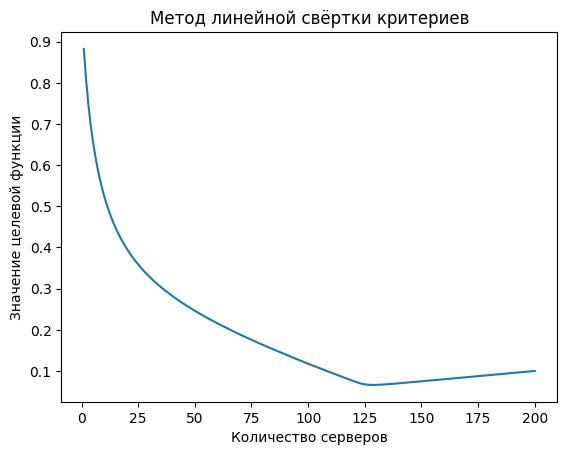

In [31]:
plt.title('Метод линейной свёртки критериев')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, linear_convolution_result)

plt.show()

In [32]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Среднее время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 129
Среднее время отклика: 40.31730574606967
Вероятность потери заявки: 0.005331434828236719
